In [1]:
import geopandas as gpd
import numpy as np
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

In [2]:
predicted_path = "/home/user/projects/clearcut_detection/data/predicted/predicted_20160103_66979721-be1b-4451-84e0-4a573236defd.geojson"
pred = gpd.read_file(predicted_path)

In [35]:
predicted_path = "/home/user/projects/clearcut_detection/data/pred_multi_2/polygons/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb.shp"
pred = gpd.read_file(predicted_path)
# pred.crs = {'init' :'epsg:32636'}
# pred = pred.to_crs({'init': "epsg:32637"})

In [4]:
def get_bounds(df):
    sum_coords = []
    for num, row in df.iterrows():
        sum_coords.extend(list(row['geometry'].exterior.coords))
    base_bound = Polygon(sum_coords).bounds
    poly = Polygon(
            [(base_bound[0], base_bound[1]),
             (base_bound[0], base_bound[3]),
             (base_bound[2], base_bound[3]),
             (base_bound[2], base_bound[1])
             ])
    return poly

In [36]:
p1 = get_bounds(pred)

In [215]:
sum_coords = []
for num, row in pred.iterrows():
    sum_coords.extend(list(row['geometry'].exterior.coords))

In [7]:
gt_path = "/home/user/projects/clearcut_detection/data/s2_data/markup/clearcuts_backup_2016-08-30/clearcuts_backup_2016-08-30.shp"
gt_poly = gpd.read_file(gt_path)
gt_poly.crs = {'init' :'epsg:4326'}
gt_poly = gt_poly.to_crs({'init': "epsg:32637"})
p2 = get_bounds(gt_poly)

In [14]:
p2.exterior.coords.xy

(array('d', [262575.75868537056, 262575.75868537056, 356329.76694924606, 356329.76694924606, 262575.75868537056]),
 array('d', [5478583.44112516, 5581428.357466508, 5581428.357466508, 5478583.44112516, 5478583.44112516]))

In [15]:
p1.exterior.coords.xy

(array('d', [267883.6331805031, 267883.6331805031, 381577.8688414728, 381577.8688414728, 267883.6331805031]),
 array('d', [5486448.779583486, 5600154.960234919, 5600154.960234919, 5486448.779583486, 5486448.779583486]))

In [37]:
p3 = p1.intersection(p2)

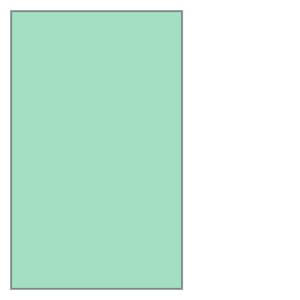

In [38]:
p3

In [121]:
united_poly = gpd.GeoDataFrame(geometry=[p3])
united_poly.to_file("/home/user/projects/clearcut_detection/data/predicted/intersection_f1.geojson", driver="GeoJSON")

In [39]:
gt_for_f1 = gt_poly[gt_poly.intersects(p3)]

In [40]:
pred_for_f1 = pred[pred.intersects(p3)]

In [126]:
pred_for_f1.to_file("/home/user/projects/clearcut_detection/data/predicted/res_for_f1.geojson", driver="GeoJSON")

In [127]:
gt_for_f1.to_file("/home/user/projects/clearcut_detection/data/predicted/gt_for_f1.geojson", driver="GeoJSON")

In [20]:
def F1_score(pred_polys, true_polys, threshold):
    """
    Calculates F1 score using shapely polygons.

    :param pred_polys: Predicted polygons.
    :param true_polys: Ground truth polygons.
    :param threshold: IoU threshold.
    :return: F1 score, recall, precision.
    """
    ious_for_each = []
    preds = [pred.buffer(0) for pred in pred_polys]
    truths = [true.buffer(0) for true in true_polys]

    if (len(preds) == 0) and (len(truths) == 0):
        precision = 1
        recall = 1
        F1 = 1
        return F1, recall, precision

    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for truth in truths:
        ious = []
        for pred in preds:
            if not truth.intersects(pred):
                ious.append(0)
            else:
                intersection = truth.intersection(pred).area
                union = truth.union(pred).area
                ious.append(intersection / union)

        if len(ious) == 0:
            false_negatives += 1
            ious_for_each.append(0)
            continue

        best = max(ious)
        ious_for_each.append(best)
        if best >= threshold:
            preds.pop(ious.index(best))
            true_positives += 1
        else:
            false_negatives += 1

    false_positives = len(preds)

    try:
        precision = true_positives / (true_positives + false_positives)
    except:
        print("Precision value undefined, setting to zero")
        precision = 0

    try:
        recall = true_positives / (true_positives + false_negatives)
    except:
        print("Recall value undefined, setting to zero")
        recall = 0

    try:
        F1 = (
            2 * (precision * recall) / (precision + recall)
        )
    except:
        print("F1 value undefined, setting to zero")
        F1 = 0
    return F1, recall, precision, ious_for_each


In [41]:
areas = [_poly.area for _poly in gt_for_f1['geometry'].values]

In [42]:
np.max(areas)

610982.4873263139

In [53]:
pred_areas = [_poly.area for _poly in pred_for_f1['geometry'].values]

In [54]:
np.max(pred_areas)

1301650.0

In [51]:
pred_filtered = pred_for_f1['geometry'].values[np.array(pred_areas) > 200]

In [52]:
len(pred_filtered)

346

In [47]:
len(gt_for_f1['geometry'].values)

965

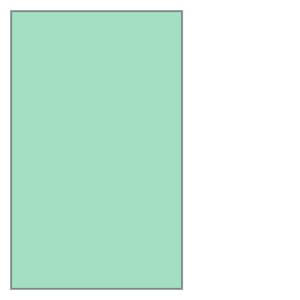

In [48]:
p3

In [56]:
metrics = F1_score(pred_filtered, gt_for_f1['geometry'].values, 0.5)
F1 = metrics[0]

In [58]:
metrics

(0.21357742181540806,
 0.14507772020725387,
 0.4046242774566474,
 [0,
  0.2327365133294235,
  0.5388351411464629,
  0,
  0.4031965507902718,
  0.23599815689642245,
  0.5745333779944075,
  0.8153085922430922,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.7296556665888255,
  0.3767597659404296,
  0.3388699307361655,
  0,
  0,
  0,
  0,
  0,
  0,
  0.4619925105449054,
  0.2562547687998717,
  0,
  0,
  0,
  0,
  0,
  0,
  0.043627501446726565,
  0.2967976310614932,
  0,
  0,
  0,
  0,
  0,
  0.24731755301988037,
  0.78963760614142,
  0,
  0,
  0,
  0.7144288630139705,
  0,
  0.5135803782489532,
  0,
  0,
  0,
  0,
  0.022009352422292464,
  0,
  0,
  0.36413818189447444,
  0.16033964471696616,
  0,
  0,
  0,
  0,
  0.6793249354077437,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.7692531210417182,
  0.11427510270429993,
  0.33229714953806866,
  0.4948764319136183,
  0,
  0.11471684191395219,
  0.441458103780249

In [186]:
len(metrics[-1])

970

In [188]:
len(pred_for_f1)

876

In [32]:
gt_for_f1['iou'] = metrics[-1]

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
gt_for_f1

,forest_typ,type,state,scene,geometry,iou
0,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((268238.9623771523 5581213.990375092,...",0.000000
1,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((268891.9675379934 5581347.614701625,...",0.000000
11,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((268104.8711944089 5525012.399323777,...",0.000000
12,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((268409.3162342672 5536597.622242976,...",0.000000
13,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((268462.5796356153 5543915.712466021,...",0.000000
14,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((268685.8843738755 5543872.034137093,...",0.000000
15,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((269687.0309217146 5543270.833525348,...",0.000000
16,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((270085.4937627824 5543093.774562048,...",0.797582
17,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((270270.3560979385 5543664.306561879,...",0.559501
18,deciduous,clearcut,open,S2A_OPER_MSI_L1C_TL_EPA__20160104T162841_A0027...,"POLYGON ((270311.8104961959 5543039.824384121,...",0.790172


In [34]:
gt_for_f1.to_file("/home/user/projects/clearcut_detection/data/predicted/gt_with_iou_bounds.geojson", driver="GeoJSON")